# Variational Nystrom

In [28]:
import numpy as np
from sklearn.utils import check_random_state
from scipy.sparse import csr_matrix, spdiags

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors

plt.style.use('ggplot')

%matplotlib inline

## Variational Nystrom Method

$X \in \mathbb{R}^{NxN}$

## Generate Data

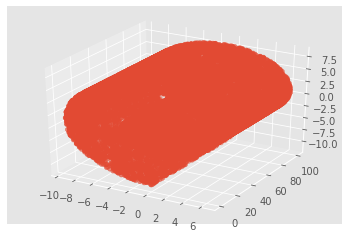

In [20]:
rng = check_random_state(1234)

N = 20000

a = (( 7 / 2 * np.pi - np.pi/2) * (rng.rand(N)**0.65) + np.pi/2)
t = 100 * rng.rand(N)

data = np.vstack((a * np.cos(a), t, a * np.sin(a))).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data[:, 0], data[:, 1], data[:, 2])

plt.show()

## Gaussian Affinities

In [30]:
%%time
# some baseline parameters
n_neighbors = 200
algorithm = 'brute'
metric = 'euclidean'
p=2
n_jobs = -1

# initialize nn model
nn_model = NearestNeighbors(
    n_neighbors=n_neighbors,
    metric=metric,
    algorithm=algorithm,
    p=p,
    n_jobs=n_jobs
)

# fit nn model to data
nn_model.fit(data);

# grab distances and indices
dists, indices = nn_model.kneighbors(
    data, 
    n_neighbors=n_neighbors, 
    return_distance=True
)



CPU times: user 18.5 s, sys: 3.42 s, total: 21.9 s
Wall time: 12.7 s


In [31]:
def heat_kernel(distances, length_scale=None):
    if length_scale is None:
        length_scale = 1.0
    return np.exp(- distances**2 / length_scale)

In [32]:
dists = heat_kernel(dists, 2)

In [33]:
# Construct sparse KNN Graph
n_samples = data.shape[0]

indptr = np.arange(0, n_samples * n_neighbors + 1, n_neighbors)

adjacency_matrix = csr_matrix((dists.ravel(), indices.ravel(), indptr), shape=(n_samples, n_samples))

# ensure that its symmetrix
adjacency_matrix = 0.5 * (adjacency_matrix + adjacency_matrix.T)